## LOADING DATASET

Model and Data: https://www.kaggle.com/code/sns5154/credit-approval-system-val-92-86-test-82-61/notebook

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn import set_config
set_config(display='diagram')
import warnings
warnings.filterwarnings('ignore')
import missingno
from xgboost import XGBRegressor
from matplotlib import rcParams

In [6]:
data = pd.read_csv('clean_dataset.csv')
print(data.shape)
data.head()

(690, 16)


,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


**Correcting logical issue in dataset**

In [7]:
data['PriorDefault'] = 1 - data['PriorDefault']
data.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,0,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,0,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,0,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,0,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,0,0,0,0,ByOtherMeans,120,0,1


***Columns such as Gender, Ethnicity and ZipCode don't matter in the study. Hence we drop it.***

> Model must not be racist, sexist, or make decisions based on geographical location of the customer

In [8]:
cols = [x for x in data.columns if x not in ["Gender","Ethnicity", "ZipCode"]]
cols

['Age',
 'Debt',
 'Married',
 'BankCustomer',
 'Industry',
 'YearsEmployed',
 'PriorDefault',
 'Employed',
 'CreditScore',
 'DriversLicense',
 'Citizen',
 'Income',
 'Approved']

In [9]:
data = data[cols]
data.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,30.83,0.000,1,1,Industrials,1.25,0,1,1,0,ByBirth,0,1
1,58.67,4.460,1,1,Materials,3.04,0,1,6,0,ByBirth,560,1
2,24.50,0.500,1,1,Materials,1.50,0,0,0,0,ByBirth,824,1
3,27.83,1.540,1,1,Industrials,3.75,0,1,5,1,ByBirth,3,1
4,20.17,5.625,1,1,Industrials,1.71,0,0,0,0,ByOtherMeans,0,1


### KEY NOTES

- We have very less information regarding the columns. To get visual insights, we need to perform *Exploratory Data Analysis*
- Clarity is still missing whether some particular columns be considered numeric or categorical.
- Binning performed on columns such as *Age*, *Debt*, *YearsEmployed*, and *CreditScore* might be more helpful.
- Does *Industry* of work column lie in ordinal or nominal category ?
- Hazy relationship between *YearsEmployed*, *Employed*, and *Approved*. Where does self-employed lie ?
- What does *PriorDefault* mean ?
- Data(target) might be imbalanced.

## TRAIN - VALIDATION - TEST SPLIT

In [10]:
from sklearn.model_selection import train_test_split

data, test = train_test_split(data,test_size=0.2, random_state=42)

In [11]:
data.shape

(552, 13)

## MISSING VALUE IMPUTATION

In [12]:
data.isnull().sum()

Age               0
Debt              0
Married           0
BankCustomer      0
Industry          0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
Income            0
Approved          0
dtype: int64

## EDA

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 278 to 102
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             552 non-null    float64
 1   Debt            552 non-null    float64
 2   Married         552 non-null    int64  
 3   BankCustomer    552 non-null    int64  
 4   Industry        552 non-null    object 
 5   YearsEmployed   552 non-null    float64
 6   PriorDefault    552 non-null    int64  
 7   Employed        552 non-null    int64  
 8   CreditScore     552 non-null    int64  
 9   DriversLicense  552 non-null    int64  
 10  Citizen         552 non-null    object 
 11  Income          552 non-null    int64  
 12  Approved        552 non-null    int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 60.4+ KB


In [14]:
data.describe()

,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Income,Approved
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,31.418188,4.604520,0.751812,0.753623,2.048134,0.487319,0.429348,2.400362,0.452899,920.070652,0.429348
std,11.760984,4.807331,0.432354,0.431291,2.923399,0.500293,0.495432,4.853296,0.498228,4787.304994,0.495432
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.730000,1.030000,1.000000,1.000000,0.165000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.460000,2.750000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,37.500000,7.000000,1.000000,1.000000,2.551250,1.000000,1.000000,3.000000,1.000000,400.000000,1.000000
max,80.250000,26.335000,1.000000,1.000000,20.000000,1.000000,1.000000,67.000000,1.000000,100000.000000,1.000000


### Pure Categorical columns

In [15]:
cat_cols = ['Married', 'BankCustomer', 'Industry', 'PriorDefault','Employed', 'DriversLicense', 'Citizen', 'Approved']
cat_data = data[cat_cols]

In [16]:
for i in enumerate(cat_cols):    
    print(i)

(0, 'Married')
(1, 'BankCustomer')
(2, 'Industry')
(3, 'PriorDefault')
(4, 'Employed')
(5, 'DriversLicense')
(6, 'Citizen')
(7, 'Approved')


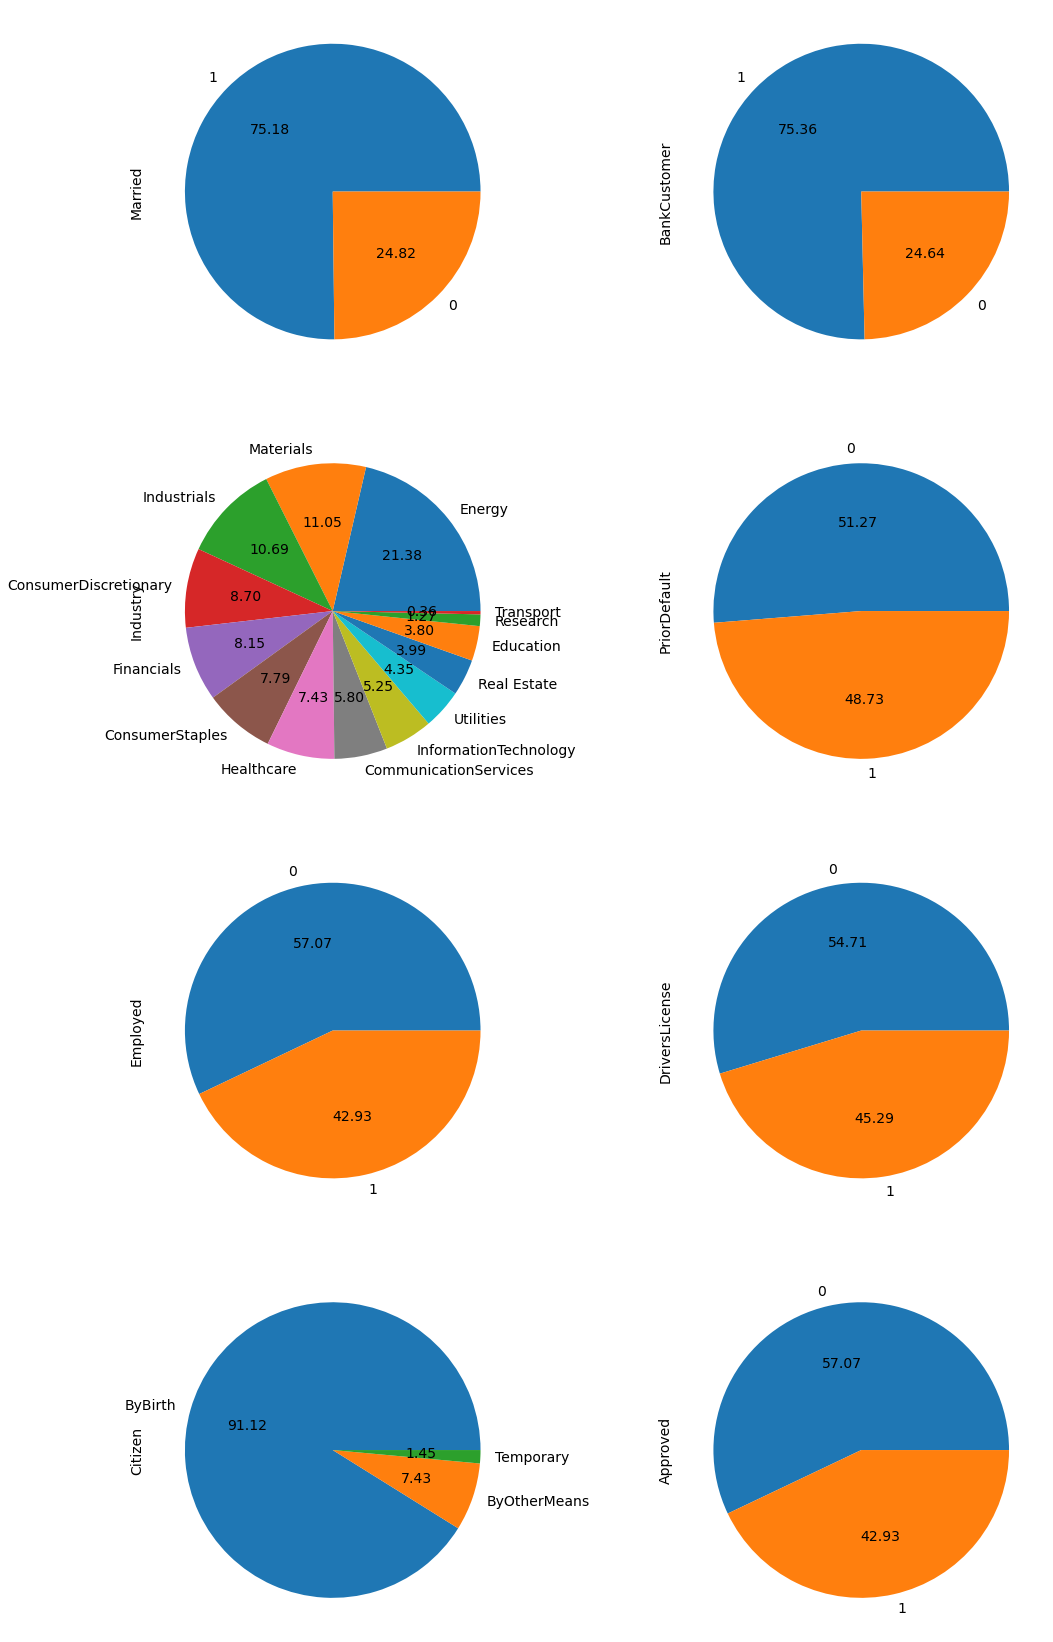

In [17]:
plt.figure(figsize=(17,24))
for i in enumerate(cat_cols):
    plt.subplot(4,2,i[0]+1);
    cat_data[i[1]].value_counts().plot(kind  = 'pie', autopct = '%.2f', textprops={'fontsize': 14})
    plt.tight_layout(pad=5.0);
    plt.ylabel(i[1],fontsize=14)

### Key Notes

- We need to club together all industries whose representation is under 6%
- Citizen columns seems off.

### Better binned columns

Binning performed on columns such as *Age*, *Debt*, *YearsEmployed*, and *CreditScore* might be more helpful.

In [18]:
better_binned_cols = ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']
better_binned_data = data[better_binned_cols]
better_binned_data.head()

,Age,Debt,YearsEmployed,CreditScore,Income
278,24.58,13.500,0.000,0,0
110,29.17,3.500,3.500,3,0
82,39.83,0.500,0.250,0,0
51,26.00,1.000,1.750,0,0
218,53.92,9.625,8.665,5,0


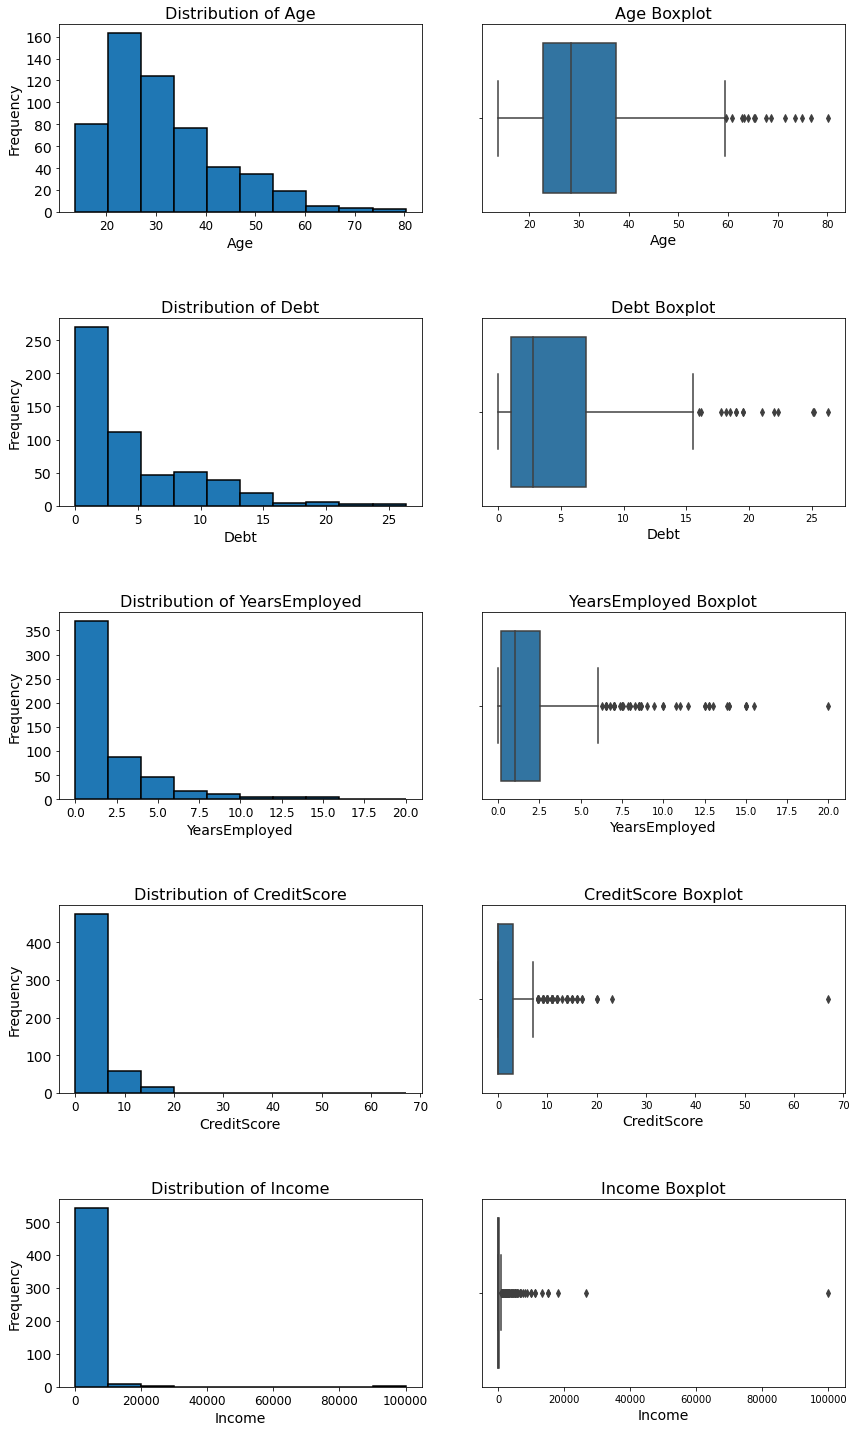

In [19]:
plt.figure(figsize=(12,20))

for i in enumerate(better_binned_cols):
    
    plt.subplot(5,2,(2*i[0])+1);
    better_binned_data[i[1]].hist(grid=False, xlabelsize=12, lw=1.5, ylabelsize=14, edgecolor = "black");
    plt.title(f"Distribution of {i[1]}",fontsize=16);
    plt.xlabel(f"{i[1]}",fontsize=14);
    plt.ylabel("Frequency",fontsize=14);
    plt.tight_layout(h_pad=5, w_pad=5)
    
    plt.subplot(5,2,(2*i[0])+2);
    sns.boxplot(better_binned_data[i[1]]);
    plt.title(f"{i[1]} Boxplot",fontsize=16);
    plt.xlabel(f'{i[1]}',fontsize=14)
    plt.tight_layout(h_pad=5, w_pad=5)


### KEY NOTES

- A great way of dealing with all those outliers is by binning the data above statistical maximum.
- *Age* can handled by binning it 4 categories (youth, youthWithResponsibility, midLife, towardsRetirement).
- *Debt* can binned into 4 categories (0to5/green, 5to10/yellow, 10to15/orange, 15+/red).
- *YearsEmployed* needs a rework.
- *CreditScore* can binned into 3 categories (0to5/red, 5to10/Yellow, 10+/Green).
- *Income* also needs a rework.

## DEALING WITH OUTLIERS 

### Fixing *Age* column

In [20]:
for idx, row in data.iterrows():
    if data.loc[idx, 'Age']< 30:
        data.loc[idx, 'Age'] = 'youth'
    
    elif data.loc[idx, 'Age']>=30 and data.loc[idx, 'Age']<40:
        data.loc[idx, 'Age'] = 'youthWithResponsibility'
    
    elif data.loc[idx, 'Age']>=40 and data.loc[idx, 'Age']<55:
        data.loc[idx, 'Age'] = 'midLife'
    
    elif data.loc[idx, 'Age']>=55:
        data.loc[idx, 'Age'] = 'towardsRetirement'
        
data.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,13.500,0,0,Healthcare,0.000,1,0,0,0,ByBirth,0,0
110,youth,3.500,1,1,Industrials,3.500,0,1,3,1,ByBirth,0,0
82,youthWithResponsibility,0.500,1,1,CommunicationServices,0.250,0,0,0,0,ByOtherMeans,0,0
51,youth,1.000,1,1,Materials,1.750,0,0,0,1,ByBirth,0,1
218,midLife,9.625,1,1,Education,8.665,0,1,5,0,ByBirth,0,1


In [21]:
data.Age.value_counts()

youth                      309
youthWithResponsibility    132
midLife                     83
towardsRetirement           28
Name: Age, dtype: int64

### Fixing *Debt* column

In [22]:
for idx, row in data.iterrows():
    
    if data.loc[idx, 'Debt']>=0 and data.loc[idx, 'Debt']<5:
        data.loc[idx, 'Debt'] = 'Green'
    
    elif data.loc[idx, 'Debt']>=5 and data.loc[idx, 'Debt']<10:
        data.loc[idx, 'Debt'] = 'Yellow'
    
    elif data.loc[idx, 'Debt']>=10 and data.loc[idx, 'Debt']<15:
        data.loc[idx, 'Debt'] = 'Orange'
    
    elif data.loc[idx, 'Debt']>=15:
        data.loc[idx, 'Debt'] = 'Red'
        
data.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,0.000,1,0,0,0,ByBirth,0,0
110,youth,Green,1,1,Industrials,3.500,0,1,3,1,ByBirth,0,0
82,youthWithResponsibility,Green,1,1,CommunicationServices,0.250,0,0,0,0,ByOtherMeans,0,0
51,youth,Green,1,1,Materials,1.750,0,0,0,1,ByBirth,0,1
218,midLife,Yellow,1,1,Education,8.665,0,1,5,0,ByBirth,0,1


In [23]:
data.Debt.value_counts()

Green     364
Yellow     94
Orange     72
Red        22
Name: Debt, dtype: int64

### Fixing *CreditScore* column

In [24]:
for idx, row in data.iterrows():
    
    if data.loc[idx, 'CreditScore']>=0 and data.loc[idx, 'CreditScore']<5:
        data.loc[idx, 'CreditScore'] = 'Red'
    
    elif data.loc[idx, 'CreditScore']>=5 and data.loc[idx, 'CreditScore']<10:
        data.loc[idx, 'CreditScore'] = 'Yellow'
    
    elif data.loc[idx, 'CreditScore']>=10:
        data.loc[idx, 'CreditScore'] = 'Green'
        # According to Boxplot distribution
        
data.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,0.000,1,0,Red,0,ByBirth,0,0
110,youth,Green,1,1,Industrials,3.500,0,1,Red,1,ByBirth,0,0
82,youthWithResponsibility,Green,1,1,CommunicationServices,0.250,0,0,Red,0,ByOtherMeans,0,0
51,youth,Green,1,1,Materials,1.750,0,0,Red,1,ByBirth,0,1
218,midLife,Yellow,1,1,Education,8.665,0,1,Yellow,0,ByBirth,0,1


In [25]:
data.CreditScore.value_counts()

Red       441
Yellow     63
Green      48
Name: CreditScore, dtype: int64

### Understanding relationship between *YearsEmployed*, *Employed*, and *Income* columns

In [26]:
print(data[data['Employed']==0].shape[0])
data[data['Employed']==0].head()

315


,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,0.000,1,0,Red,0,ByBirth,0,0
82,youthWithResponsibility,Green,1,1,CommunicationServices,0.250,0,0,Red,0,ByOtherMeans,0,0
51,youth,Green,1,1,Materials,1.750,0,0,Red,1,ByBirth,0,1
446,youth,Green,1,1,Energy,0.165,1,0,Red,0,ByBirth,0,0
314,youth,Green,0,0,ConsumerStaples,0.250,1,0,Red,0,ByBirth,0,0


In [27]:
print(data[(data['Employed']==0) &  (data['Approved']==1)].shape[0])
data[(data['Employed']==0) &  (data['Approved']==1)].head()

73


,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
51,youth,Green,1,1,Materials,1.750,0,0,Red,1,ByBirth,0,1
18,youth,Green,1,1,Real Estate,0.665,0,0,Red,1,ByBirth,0,1
215,midLife,Green,1,1,ConsumerStaples,3.500,0,0,Red,0,ByOtherMeans,0,1
174,youth,Orange,1,1,Materials,1.335,0,0,Red,0,ByBirth,0,1
163,youthWithResponsibility,Green,0,0,Education,0.040,0,0,Red,1,ByBirth,0,1


In [28]:
print(data[(data['Employed']==0) &  (data['Approved']==1) &  (data['YearsEmployed']==0.0)].shape[0])
data[(data['Employed']==0) &  (data['Approved']==1) &  (data['YearsEmployed']==0.0)].head()

10


,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
513,youth,Yellow,1,1,Education,0.0,0,0,Red,0,ByBirth,0,1
236,youth,Green,1,1,ConsumerDiscretionary,0.0,0,0,Red,1,ByBirth,0,1
622,youth,Green,1,1,Energy,0.0,1,0,Red,0,Temporary,0,1
584,youth,Red,0,0,Education,0.0,0,0,Red,0,ByBirth,13212,1
53,youthWithResponsibility,Green,1,1,Industrials,0.0,0,0,Red,1,ByBirth,200,1


In [29]:
data[data['YearsEmployed']==0].head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,0.0,1,0,Red,0,ByBirth,0,0
89,midLife,Green,1,1,Research,0.0,0,0,Red,1,ByBirth,27,0
601,midLife,Green,0,0,Energy,0.0,1,0,Red,1,ByBirth,1,0
447,youth,Green,1,1,Healthcare,0.0,1,0,Red,0,ByBirth,1,0
513,youth,Yellow,1,1,Education,0.0,0,0,Red,0,ByBirth,0,1


In [30]:
data[data['Income']==0].head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,0.000,1,0,Red,0,ByBirth,0,0
110,youth,Green,1,1,Industrials,3.500,0,1,Red,1,ByBirth,0,0
82,youthWithResponsibility,Green,1,1,CommunicationServices,0.250,0,0,Red,0,ByOtherMeans,0,0
51,youth,Green,1,1,Materials,1.750,0,0,Red,1,ByBirth,0,1
218,midLife,Yellow,1,1,Education,8.665,0,1,Yellow,0,ByBirth,0,1


In [31]:
data[(data['Income']==0) & (data['Employed']==0)]['Approved'].value_counts()

0    136
1     46
Name: Approved, dtype: int64

In [32]:
data[(data['Income']==0) & (data['Employed']==0)]['YearsEmployed'].value_counts()

0.000     25
0.250     16
0.500     13
0.085     12
0.125      9
0.040      7
3.000      7
0.165      6
1.500      6
1.000      6
3.500      5
1.165      4
0.835      4
0.750      4
2.500      3
1.250      3
0.875      3
1.750      3
2.250      2
0.665      2
4.000      2
0.415      2
2.415      2
0.540      2
5.000      2
5.750      2
2.000      2
8.500      2
10.000     1
6.500      1
5.125      1
12.750     1
0.210      1
1.710      1
1.585      1
11.000     1
2.085      1
3.085      1
3.250      1
5.250      1
7.000      1
0.455      1
10.750     1
15.000     1
1.375      1
1.335      1
7.500      1
2.585      1
4.500      1
8.290      1
4.250      1
4.580      1
0.290      1
12.500     1
Name: YearsEmployed, dtype: int64

In [33]:
data[(data['YearsEmployed']==0) & (data['Employed']==0)]['Income'].value_counts()

0         25
1          5
27         2
50         1
5200       1
1000       1
32         1
13212      1
20         1
200        1
60         1
1110       1
100000     1
12         1
Name: Income, dtype: int64

>There is no such relationship between *YearsEmployed*, *Employed*, and *Income* and that might be precisely because not employed also means self-employed/business/enterpreneurship.

In [34]:
data[['YearsEmployed', 'Income']].describe().T

,count,mean,std,min,25%,50%,75%,max
YearsEmployed,552.0,2.048134,2.923399,0.0,0.165,1.0,2.55125,20.0
Income,552.0,920.070652,4787.304994,0.0,0.000,5.0,400.00000,100000.0


In [35]:
data['YearsEmployed'].value_counts()

0.000     59
0.250     32
0.125     26
0.040     26
1.000     25
          ..
1.875      1
3.125      1
9.000      1
6.750      1
13.000     1
Name: YearsEmployed, Length: 117, dtype: int64

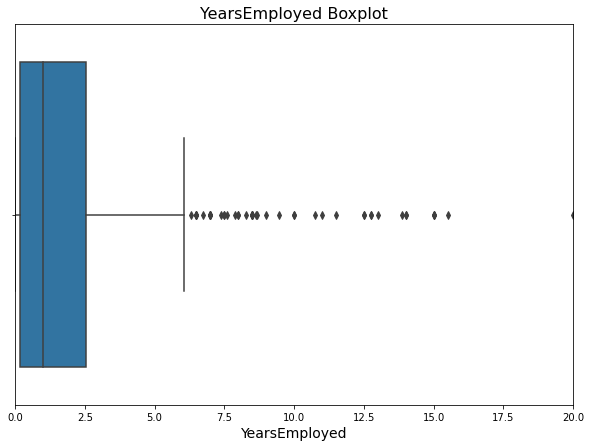

In [36]:
plt.figure(figsize = (10,7));
sns.boxplot(data['YearsEmployed']);
plt.title(f"YearsEmployed Boxplot",fontsize=16);
plt.xlabel(f'YearsEmployed',fontsize=14)
xmax = max(data['YearsEmployed'])
xmin = min(data['YearsEmployed'])
plt.xlim([xmin,xmax]);

In [37]:
data['Income'].value_counts()

0       231
1        21
2         8
500       8
5         7
       ... 
2510      1
53        1
2803      1
245       1
38        1
Name: Income, Length: 205, dtype: int64

### Fixing *YearsEmployed* column

In [38]:
for idx, row in data.iterrows():
    
    if data.loc[idx, 'YearsEmployed']>=0 and data.loc[idx, 'YearsEmployed']<0.5:
        data.loc[idx, 'YearsEmployed'] = 'Fresher'
    
    elif data.loc[idx, 'YearsEmployed']>=0.5 and data.loc[idx, 'YearsEmployed']<2.56:
        data.loc[idx, 'YearsEmployed'] = 'Experienced'
    
    elif data.loc[idx, 'YearsEmployed']>=2.56:
        data.loc[idx, 'YearsEmployed'] = 'Expert'
        # According to distribution statistics
        
data.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,Fresher,1,0,Red,0,ByBirth,0,0
110,youth,Green,1,1,Industrials,Expert,0,1,Red,1,ByBirth,0,0
82,youthWithResponsibility,Green,1,1,CommunicationServices,Fresher,0,0,Red,0,ByOtherMeans,0,0
51,youth,Green,1,1,Materials,Experienced,0,0,Red,1,ByBirth,0,1
218,midLife,Yellow,1,1,Education,Expert,0,1,Yellow,0,ByBirth,0,1


### Fixing *Income* column

In [39]:
data['Income'].quantile([0.33])

0.33    0.0
Name: Income, dtype: float64

In [40]:
data['Income'].quantile([0.66])

0.66    148.98
Name: Income, dtype: float64

In [41]:
for idx, row in data.iterrows():
    
    if data.loc[idx, 'Income']==0.0:
        data.loc[idx, 'Income'] = 'Poor'
    
    elif data.loc[idx, 'Income']>=0.0 and data.loc[idx, 'Income']<150.0:
        data.loc[idx, 'Income'] = 'Middle Class'
    
    elif data.loc[idx, 'Income']>=150.0:
        data.loc[idx, 'Income'] = 'Rich'
        # According to distribution statistics
        
data.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
278,youth,Orange,0,0,Healthcare,Fresher,1,0,Red,0,ByBirth,Poor,0
110,youth,Green,1,1,Industrials,Expert,0,1,Red,1,ByBirth,Poor,0
82,youthWithResponsibility,Green,1,1,CommunicationServices,Fresher,0,0,Red,0,ByOtherMeans,Poor,0
51,youth,Green,1,1,Materials,Experienced,0,0,Red,1,ByBirth,Poor,1
218,midLife,Yellow,1,1,Education,Expert,0,1,Yellow,0,ByBirth,Poor,1


## FEATURE ENGINEERING

In [42]:
data.sample(5)

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
25,youth,Green,1,1,Energy,Experienced,0,1,Red,0,ByBirth,Poor,1
357,youth,Green,1,1,Materials,Fresher,1,0,Red,1,ByBirth,Poor,0
62,youth,Green,0,0,Materials,Experienced,0,1,Red,1,ByBirth,Rich,1
259,youth,Green,0,0,Energy,Fresher,1,0,Red,0,ByBirth,Poor,0
559,youth,Green,1,1,Materials,Experienced,0,1,Yellow,1,ByBirth,Rich,1


***Now on, our complete dataset contains only categorical columns***

### Nominal categorical data

- Married
- BankCustomer
- PriorDefault
- Employed
- DriversLicense

### Ordinal categorical data

- Debt
- YearsEmployed
- CreditScore
- Income

### Doubtful Ones

- Age
- Industry
- Citizen

***More than 90 percent variance in Citizen column is clearly explained. Hence it has very minimal information gain (less decrease in entropy). So we remove the Citizen column***.

In [43]:
data.drop(['Citizen'], axis=1, inplace=True)
data.sample(10)

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Income,Approved
368,youth,Orange,0,0,Financials,Expert,1,0,Red,1,Middle Class,0
440,youth,Green,1,1,Financials,Experienced,1,1,Green,0,Poor,0
656,youth,Green,1,1,Energy,Experienced,1,1,Red,1,Middle Class,0
343,youthWithResponsibility,Green,1,1,ConsumerDiscretionary,Fresher,1,0,Red,0,Poor,0
475,youth,Green,1,1,Real Estate,Experienced,1,0,Red,1,Poor,0
195,youth,Yellow,0,0,Energy,Experienced,0,1,Yellow,1,Middle Class,1
459,youth,Green,0,0,Energy,Experienced,1,0,Red,1,Poor,0
625,youth,Orange,1,1,Energy,Experienced,1,0,Red,0,Poor,0
614,youthWithResponsibility,Green,1,1,Energy,Fresher,1,0,Red,0,Poor,0
559,youth,Green,1,1,Materials,Experienced,0,1,Yellow,1,Rich,1


### *Age* column hypothesis testing

In [44]:
data[data['Approved']==1]['Age'].value_counts()

youth                      113
youthWithResponsibility     56
midLife                     48
towardsRetirement           20
Name: Age, dtype: int64

In [45]:
data[data['Approved']==0]['Age'].value_counts()

youth                      196
youthWithResponsibility     76
midLife                     35
towardsRetirement            8
Name: Age, dtype: int64

In [46]:
youthApprovedRatio = 113/(113+196)
youthApprovedRatio

0.3656957928802589

In [47]:
youthWithResponsibilitiesApprovedRatio = 56/(56+76)
youthWithResponsibilitiesApprovedRatio

0.42424242424242425

In [48]:
midLifeApprovedRatio = 48/(48+35)
midLifeApprovedRatio

0.5783132530120482

In [49]:
towardsRetirementApprovedRatio = 20/(20+8)
towardsRetirementApprovedRatio

0.7142857142857143

***Age* column is evidently an Ordinal Categorical feature**

### Fixing *Industry* column

In [50]:
data.Industry.value_counts()

Energy                   118
Materials                 61
Industrials               59
ConsumerDiscretionary     48
Financials                45
ConsumerStaples           43
Healthcare                41
CommunicationServices     32
InformationTechnology     29
Utilities                 24
Real Estate               22
Education                 21
Research                   7
Transport                  2
Name: Industry, dtype: int64

In [51]:
for idx, row in data.iterrows():
    if data.loc[idx, 'Industry'] in ['Utilities', 'Real Estate', 'Education', 'Research', 'Transport']:
        data.loc[idx, 'Industry'] = 'Others'

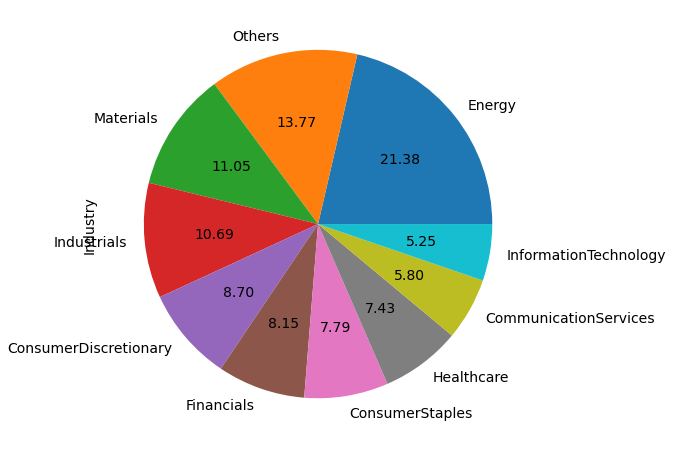

In [52]:
plt.figure(figsize = (10,10))
data['Industry'].value_counts().plot(kind  = 'pie', autopct = '%.2f', textprops={'fontsize': 14})
plt.tight_layout(pad=5.0);
plt.ylabel('Industry',fontsize=14);

---
## FEATURE SELECTION

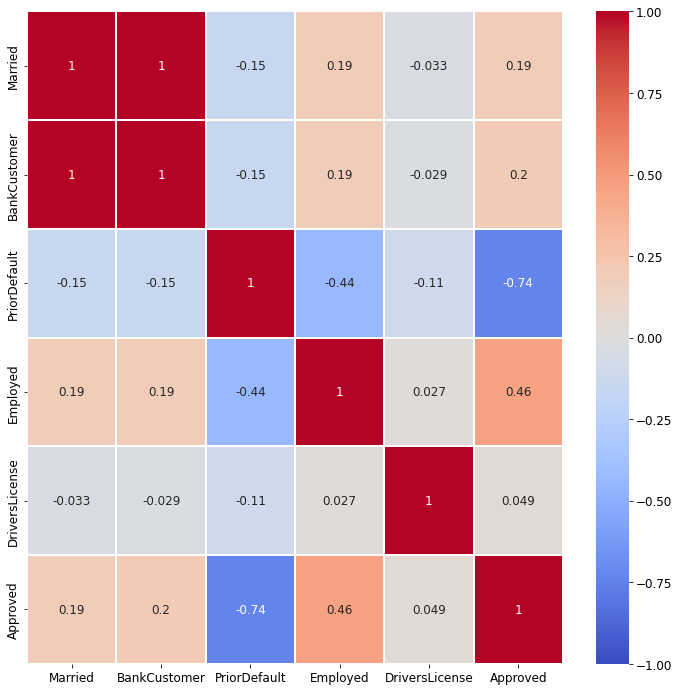

In [53]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax, lw=0.2, edgecolor="white");

In [54]:
print(data[data['Married']==1].shape[0])
data[data['Married']==1]['BankCustomer'].value_counts()

415


1    415
Name: BankCustomer, dtype: int64

In [55]:
print(data[data['Married']==0].shape[0])
data[data['Married']==0]['BankCustomer'].value_counts()

137


0    136
1      1
Name: BankCustomer, dtype: int64

In [56]:
data.drop(['Married'], axis = 1, inplace= True)

### Key Notes:

- According to this *DriversLicense* has almost nil correlation with *Approved*. Hence, no new information. We still need to confirm this.
- *Married* and *BankCustomer* are redundant. We removed *Married* because of less correlation. This finding is **weird**

---
## FEATURE IMPORTANCE

### Relative importance of *DriversLicense* if any

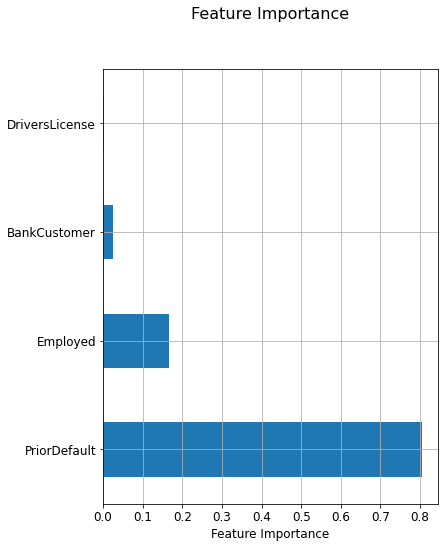

In [57]:
from sklearn.ensemble import ExtraTreesClassifier

temp_df = data[['DriversLicense','BankCustomer', 'Employed', 'PriorDefault', 'Approved']]
X_train_dummy = pd.get_dummies(temp_df.iloc[:,:-1], drop_first=True)
y_train_dummy = pd.get_dummies(temp_df.iloc[:,-1], drop_first=True)
model = ExtraTreesClassifier()
model.fit(X_train_dummy, y_train_dummy)
fig = plt.figure(figsize=(6,8))
feature_imps = pd.Series(model.feature_importances_, index = X_train_dummy.columns)
feature_imps.nlargest(10).plot(kind='barh')
plt.grid(True)
plt.title("Feature Importance", pad=50, fontsize=16)
plt.xlabel('Feature Importance')
plt.show()

### Relative importance of *Industry* if any

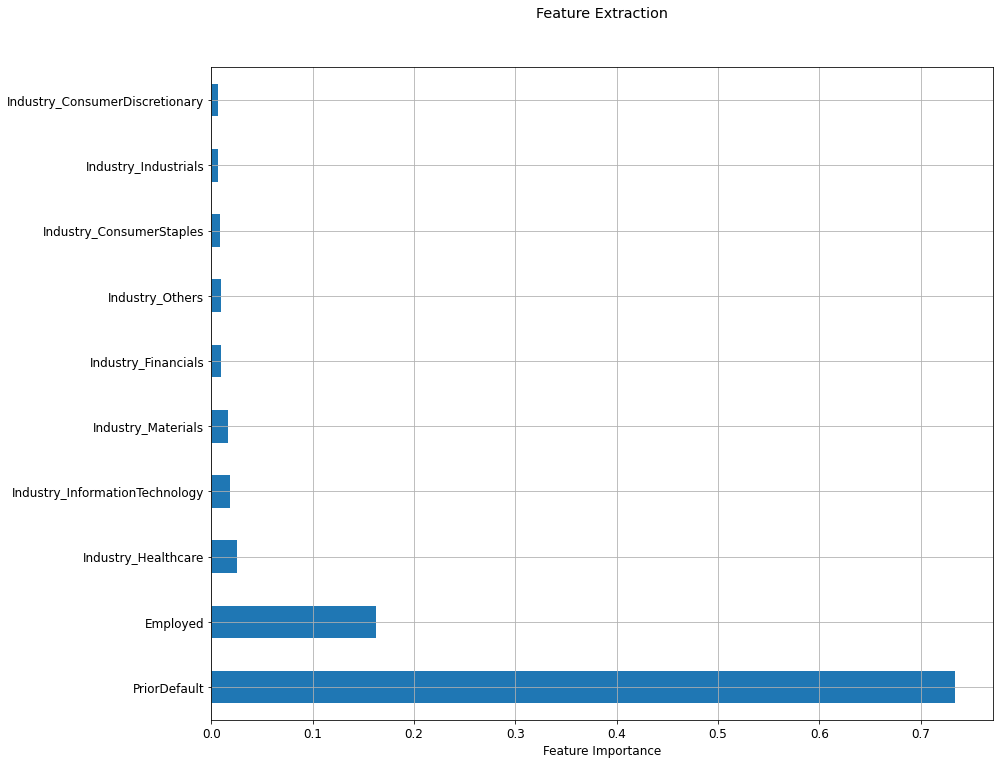

In [58]:
temp_df = data[['Industry', 'Employed', 'PriorDefault', 'Approved']]
X_train_dummy = pd.get_dummies(temp_df.iloc[:,:-1], drop_first=True)
y_train_dummy = pd.get_dummies(temp_df.iloc[:,-1], drop_first=True)
model = ExtraTreesClassifier()
model.fit(X_train_dummy, y_train_dummy)
fig = plt.figure(figsize=(14,12))
feature_imps = pd.Series(model.feature_importances_, index = X_train_dummy.columns)
feature_imps.nlargest(10).plot(kind='barh')
plt.grid(True)
plt.title("Feature Extraction", pad=50)
plt.xlabel('Feature Importance')
plt.show()

In [59]:
# data.drop('DriversLicense', axis=1, inplace=True)

### Key Notes:

- Negligible variation in importance among the industries and almost nil importance compared to other features.
- It is now confirmed that *DriversLicense* has almost no impact on credit approval. **But as we are complying to constitutional rules and regulations, our model must be biased towards a client who produces more qulaity legal documents. This enables proper profiling of the client***

---
## FEATURE TRANSFORMATION

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

X_train, X_validate, y_train, y_validate = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size = 0.1, random_state = 42)

transformer = ColumnTransformer(transformers = [
    ('ohe', OneHotEncoder(sparse = False, drop='first'), ['Industry']),
    ('oe1', OrdinalEncoder(categories = [["youth", "youthWithResponsibility", "midLife", "towardsRetirement"]]),['Age']),
    ('oe2', OrdinalEncoder(categories = [["Red", "Orange", "Yellow", "Green"]]),['Debt']),
    ('oe3', OrdinalEncoder(categories = [["Fresher", "Experienced", "Expert"]]),['YearsEmployed']),
    ('oe4', OrdinalEncoder(categories = [["Red", "Yellow", "Green"]]),['CreditScore']),
    ('oe5', OrdinalEncoder(categories = [["Poor", "Middle Class", "Rich"]]),['Income'])
    ], remainder = 'passthrough')

X_train = transformer.fit_transform(X_train)
X_validate = transformer.transform(X_validate)

In [61]:
print(X_train.shape)
X_train

(496, 18)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [62]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['Industry']),
                                ('oe1',
                                 OrdinalEncoder(categories=[['youth',
                                                             'youthWithResponsibility',
                                                             'midLife',
                                                             'towardsRetirement']]),
                                 ['Age']),
                                ('oe2',
                                 OrdinalEncoder(categories=[['Red', 'Orange',
                                                             'Yellow',
                                                             'Green']]),
                                 ['Debt']),
                                ('oe3',
                                 OrdinalEncoder(categories=[['Fresher',
                                                             'Experienced',
                                                             'Expert']]),
                                 ['YearsEmployed']),
                                ('oe4',
                                 OrdinalEncoder(categories=[['Red', 'Yellow',
                                                             'Green']]),
                                 ['CreditScore']),
                                ('oe5',
                                 OrdinalEncoder(categories=[['Poor',
                                                             'Middle Class',
                                                             'Rich']]),
                                 ['Income'])])

---
## DATA UPSAMPLING USING *SMOTEN*

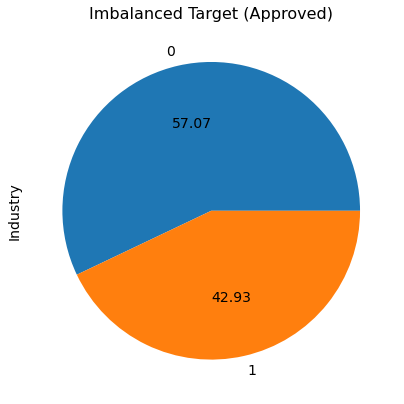

In [63]:
plt.figure(figsize = (7,7))
data['Approved'].value_counts().plot(kind  = 'pie', autopct = '%.2f', textprops={'fontsize': 14})
plt.tight_layout(pad=5.0);
plt.ylabel('Industry',fontsize=14);
plt.title('Imbalanced Target (Approved)',fontsize=16);


In [64]:
from collections import Counter
print(f'Non- Resampled dataset samples per class {Counter(y_train)}')

Non- Resampled dataset samples per class Counter({0: 284, 1: 212})


In [66]:
from imblearn.over_sampling import SMOTEN

sm = SMOTEN(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [67]:
print(f'Resampled dataset samples per class {Counter(y_train)}')

Resampled dataset samples per class Counter({0: 284, 1: 284})


In [68]:
print(X_train.shape)
X_train

(568, 18)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [69]:
y_train

0      0
1      1
2      0
3      0
4      0
      ..
563    1
564    1
565    1
566    1
567    1
Name: Approved, Length: 568, dtype: int64

In [70]:
y_train=y_train.values
print(y_train.shape)
y_train

(568,)


array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,

---
## FEATURE EXTRACTION

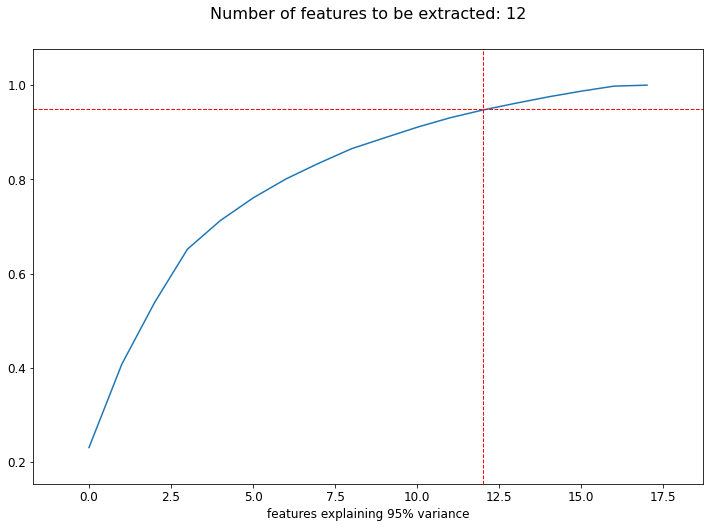

In [71]:
from sklearn.decomposition import PCA

plt.figure(figsize=(12,8))
pca_dummy = PCA(n_components=None, random_state=42)
X_dummy = X_train
X_dummy = pca_dummy.fit_transform(X_dummy)
plt.plot(np.cumsum(pca_dummy.explained_variance_ratio_))
plt.axhline(y = 0.95, c='r', linewidth =1, linestyle='--', label = "Explained Variance: 95%")
plt.axvline(x=12, c='r', linestyle = '--', lw=1)
plt.margins(0.1)
plt.legend=True
plt.title('Number of features to be extracted: 12', pad=30, fontsize = 16)
plt.xlabel('features explaining 95% variance')
plt.show();

In [72]:
pca = PCA(n_components=12, random_state=42)
X_train = pca.fit_transform(X_train)
X_validate = pca.transform(X_validate)

In [73]:
print(X_train.shape, X_validate.shape)
print(y_train.shape, y_validate.shape)

(568, 12) (56, 12)
(568,) (56,)


---
## ML MODELLING

1. Linear Models
    - Logistic Regression
    - SGDClassifier
    - PassiveAggressiveClassifier
    
    
2. Kernel-based Models
    - Support Vector Classifier
    
    
3. Non-Parameteric Models
    - KNeighbors Classifier
    
    
4. Bayesian Models
    - Bernoulli Naive Bayes
    
    
5. Tree-Based Models
    - Decision Tree Classifier
    - Extra Tree Classifier
    
    
6. Ensemble Models
    - Bagging Classifier
    - AdaBoost 
    - Random Forest
    - Stacking Classifier
    - Histogram Gradient Boosting Classifier
    - Extreme Gradient Boosting Classifier

---
### Metric Used: Accuracy, F1-Score

In [74]:
from sklearn.metrics import accuracy_score, f1_score

---
### Linear Models | Base model accuracy: 78.57%

#### Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)

In [76]:
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [77]:
y_pred = lr.predict(X_validate)

In [78]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 78.57%
F1-Score: 79.31%


#### Stochastic Gradient Descent Classifier

In [79]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)

In [80]:
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [81]:
y_pred = sgd.predict(X_validate)

In [82]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 78.57%
F1-Score: 79.31%


#### Passive Aggressive Classifier

In [83]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(random_state=42)

In [84]:
pac.fit(X_train, y_train)

PassiveAggressiveClassifier(random_state=42)

In [85]:
y_pred = pac.predict(X_validate)

In [86]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 78.57%
F1-Score: 75.00%


---
### Kernel based models | Base model accuracy: 83.93%

#### Support Vector Classifier

In [87]:
from sklearn.svm import SVC

svc = SVC(C=0.01, random_state =42)

In [88]:
svc.fit(X_train, y_train)

SVC(C=0.01, random_state=42)

In [89]:
y_pred = svc.predict(X_validate)

In [90]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 83.93%
F1-Score: 83.02%


### Non-parameteric models | Base model accuracy: 91.07%

#### K-Nearest Neighbors

In [91]:
k = (X_train.shape[0]**(0.5))
k

23.83275057562597

In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=19)

In [93]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [94]:
y_pred = knn.predict(X_validate)

In [95]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 91.07%
F1-Score: 90.20%


---
### Bayesian Models | Base model accuracy: 73.21%

#### Bernoulli Naive Bayes Classifier

In [96]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

In [97]:
bnb.fit(X_train, y_train)

BernoulliNB()

In [98]:
y_pred = bnb.predict(X_validate)

In [99]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 73.21%
F1-Score: 72.73%


---
### Tree-based Models | Base model accuracy: 78.57%

#### Decision Tree Classifier

In [100]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth = 3, random_state=42)

In [101]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [102]:
y_pred = dtc.predict(X_validate)

In [103]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 73.21%
F1-Score: 71.70%


#### Extra-trees Classifier

In [104]:
from sklearn.tree import ExtraTreeClassifier

etc = ExtraTreeClassifier(max_depth=15,random_state=42)

In [105]:
etc.fit(X_train, y_train)

ExtraTreeClassifier(max_depth=15, random_state=42)

In [106]:
y_pred = etc.predict(X_validate)

In [107]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 78.57%
F1-Score: 76.00%


---
### Ensemble Models | Base model accuracy: 92.86%

#### Bagging Classifier

In [108]:
from sklearn.ensemble import BaggingClassifier

knn = KNeighborsClassifier(n_neighbors=19)
bgc = BaggingClassifier(base_estimator= knn, n_estimators=5, random_state=42)

In [109]:
bgc.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=19),
                  n_estimators=5, random_state=42)

In [110]:
y_pred = bgc.predict(X_validate)

In [111]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 91.07%
F1-Score: 90.20%


#### Adam Boosting Classifier

In [112]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=15, learning_rate=1.0, random_state=42)

In [113]:
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=15, random_state=42)

In [114]:
y_pred = ada.predict(X_validate)

In [115]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 82.14%
F1-Score: 81.48%


#### Random Forest Classifier

In [116]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=50, random_state=42)

In [117]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [118]:
y_pred = rfc.predict(X_validate)

In [119]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 71.43%
F1-Score: 72.41%


#### Histogram Gradient Boosting

In [120]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(learning_rate=0.1, random_state=42)

In [121]:
hgb.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [122]:
y_pred = rfc.predict(X_validate)

In [123]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 71.43%
F1-Score: 72.41%


#### Extreme Gradient Boosting Classifier

In [124]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)

In [125]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [126]:
y_pred = xgb.predict(X_validate)

In [127]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 80.36%
F1-Score: 79.25%


#### Stacking Classifier

In [128]:
from sklearn.ensemble import StackingClassifier

knn19 = KNeighborsClassifier(n_neighbors=19)
knn21 = KNeighborsClassifier(n_neighbors=21)
knn23 = KNeighborsClassifier(n_neighbors=23)

bgc19 = BaggingClassifier(base_estimator= knn19, n_estimators=5, random_state=42)
bgc21 = BaggingClassifier(base_estimator= knn21, n_estimators=5, random_state=42)
bgc23 = BaggingClassifier(base_estimator= knn23, n_estimators=5, random_state=42)

stc = StackingClassifier(estimators = [
    ('bgc19',bgc19),
    ('bgc21',bgc21),
    ('bgc23',bgc23)
])

In [129]:
stc.fit(X_train, y_train)

StackingClassifier(estimators=[('bgc19',
                                BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=19),
                                                  n_estimators=5,
                                                  random_state=42)),
                               ('bgc21',
                                BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=21),
                                                  n_estimators=5,
                                                  random_state=42)),
                               ('bgc23',
                                BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=23),
                                                  n_estimators=5,
                                                  random_state=42))])

In [130]:
y_pred = stc.predict(X_validate)

In [131]:
print(f'Accuracy: {accuracy_score(y_validate, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_validate, y_pred)*100:.2f}%')

Accuracy: 92.86%
F1-Score: 92.00%


## HYPERPARAMETER TUNING

*Selected Model: **Bagging Classifier** with **KNeighborClassifier** as a base estimator*

Validation set Accuracy: **92.86%** 

Validation set F1-score: **92.00%**

In [132]:
accuracies = []
k = []
for i in range(5,50):
    k.append(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    bgc = BaggingClassifier(base_estimator= knn, n_estimators=5, random_state=42)
    bgc.fit(X_train, y_train)
    y_pred = bgc.predict(X_validate)
    accuracies.append(accuracy_score(y_validate, y_pred)*100)

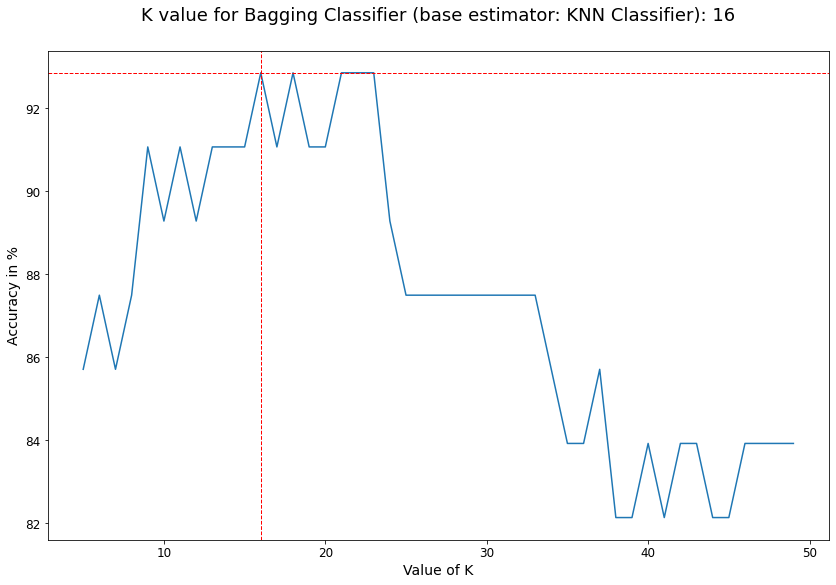

In [133]:
plt.figure(figsize=(14,9))
plt.plot(k,accuracies, lw = 1.5, linestyle="-");
plt.axhline(y = 92.86, c='r', linewidth =1, linestyle='--')
plt.axvline(x=16, c='r', linestyle = '--', lw=1)
plt.title("K value for Bagging Classifier (base estimator: KNN Classifier): 16", fontsize=18, pad=30)
plt.xlabel("Value of K",fontsize=14)
plt.ylabel("Accuracy in %",fontsize=14);


> **Since 16 is an even number. It is unsafe for KNN Classifier**

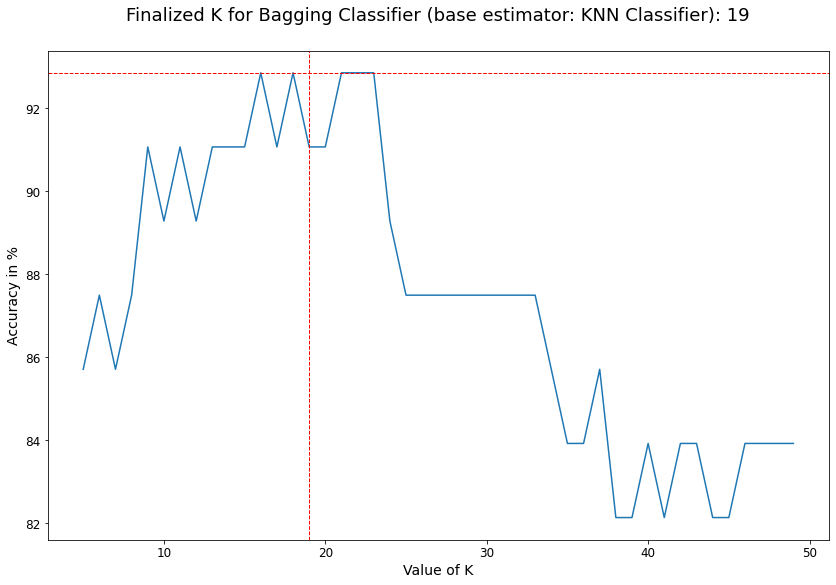

In [134]:
plt.figure(figsize=(14,9))
plt.plot(k,accuracies, lw = 1.5, linestyle="-");
plt.axhline(y = 92.86, c='r', linewidth =1, linestyle='--')
plt.axvline(x=19, c='r', linestyle = '--', lw=1)
plt.title("Finalized K for Bagging Classifier (base estimator: KNN Classifier): 19", fontsize=18, pad=30)
plt.xlabel("Value of K",fontsize=14)
plt.ylabel("Accuracy in %",fontsize=14);

## MODELLING RESULTS

**Now we check how our hyperparameter tuned model performs on Test set, which I have never seen/plotted(viz).**

In [135]:
test.isnull().sum()

Age               0
Debt              0
Married           0
BankCustomer      0
Industry          0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
Income            0
Approved          0
dtype: int64

In [136]:
test.head()

,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
286,28.46,1.5,1,1,Healthcare,0.0,1,1,2,1,ByBirth,105,0
511,46.00,4.0,1,1,Research,0.0,0,0,0,0,ByBirth,960,1
257,20.00,0.0,1,1,Real Estate,0.5,1,0,0,0,ByBirth,0,0
336,47.33,6.5,1,1,Energy,1.0,1,0,0,1,ByBirth,228,0
318,19.17,0.0,0,0,CommunicationServices,0.0,1,0,0,1,ByOtherMeans,1,1


In [137]:
for idx, row in test.iterrows():
    if test.loc[idx, 'Age']< 30:
        test.loc[idx, 'Age'] = 'youth'
    
    elif test.loc[idx, 'Age']>=30 and test.loc[idx, 'Age']<40:
        test.loc[idx, 'Age'] = 'youthWithResponsibility'
    
    elif test.loc[idx, 'Age']>=40 and test.loc[idx, 'Age']<55:
        test.loc[idx, 'Age'] = 'midLife'
    
    elif test.loc[idx, 'Age']>=55:
        test.loc[idx, 'Age'] = 'towardsRetirement'
        

for idx, row in test.iterrows():
    
    if test.loc[idx, 'Debt']>=0 and test.loc[idx, 'Debt']<5:
        test.loc[idx, 'Debt'] = 'Green'
    
    elif test.loc[idx, 'Debt']>=5 and test.loc[idx, 'Debt']<10:
        test.loc[idx, 'Debt'] = 'Yellow'
    
    elif test.loc[idx, 'Debt']>=10 and test.loc[idx, 'Debt']<15:
        test.loc[idx, 'Debt'] = 'Orange'
    
    elif test.loc[idx, 'Debt']>=15:
        test.loc[idx, 'Debt'] = 'Red'

for idx, row in test.iterrows():
    
    if test.loc[idx, 'CreditScore']>=0 and test.loc[idx, 'CreditScore']<5:
        test.loc[idx, 'CreditScore'] = 'Red'
    
    elif test.loc[idx, 'CreditScore']>=5 and test.loc[idx, 'CreditScore']<10:
        test.loc[idx, 'CreditScore'] = 'Yellow'
    
    elif test.loc[idx, 'CreditScore']>=10:
        test.loc[idx, 'CreditScore'] = 'Green'

for idx, row in test.iterrows():
    
    if test.loc[idx, 'YearsEmployed']>=0 and test.loc[idx, 'YearsEmployed']<0.5:
        test.loc[idx, 'YearsEmployed'] = 'Fresher'
    
    elif test.loc[idx, 'YearsEmployed']>=0.5 and test.loc[idx, 'YearsEmployed']<2.56:
        test.loc[idx, 'YearsEmployed'] = 'Experienced'
    
    elif test.loc[idx, 'YearsEmployed']>=2.56:
        test.loc[idx, 'YearsEmployed'] = 'Expert'


for idx, row in test.iterrows():
    
    if test.loc[idx, 'Income']==0.0:
        test.loc[idx, 'Income'] = 'Poor'
    
    elif test.loc[idx, 'Income']>=0.0 and test.loc[idx, 'Income']<150.0:
        test.loc[idx, 'Income'] = 'Middle Class'
    
    elif test.loc[idx, 'Income']>=150.0:
        test.loc[idx, 'Income'] = 'Rich'


test.drop(['Citizen'], axis=1, inplace=True)

for idx, row in test.iterrows():
    if test.loc[idx, 'Industry'] in ['Utilities', 'Real Estate', 'Education', 'Research', 'Transport']:
        test.loc[idx, 'Industry'] = 'Others'

test.drop(['Married'], axis = 1, inplace= True)
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]
X_test = transformer.transform(X_test)
y_test = y_test.values
X_test = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=19)
bgc = BaggingClassifier(base_estimator= knn, n_estimators=5, random_state=42)
bgc.fit(X_train, y_train)
y_pred = bgc.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%\nF1-Score: {f1_score(y_test, y_pred)*100:.2f}%')


Accuracy: 82.61%
F1-Score: 82.35%


In [138]:
results_df = pd.DataFrame({'Dataset': ['Validation Set', 'Test Set'], 'Accuracy score':['92.86%', '82.61%'], 'F1-Score': ['92%','82.35%']})
results_df.set_index('Dataset', inplace=True)
results_df

,Accuracy score,F1-Score
Dataset,,
Validation Set,92.86%,92%
Test Set,82.61%,82.35%


#### Accuracy on Test data: 82.61%
Drop in accuracy: **10%**

## SAVING ML MODEL

In [139]:
import joblib
filename = 'bgc.sav'
joblib.dump(bgc, filename)
filename = 'pca.sav'
joblib.dump(pca, filename)
filename = 'transformer.sav'
joblib.dump(transformer, filename)

['transformer.sav']

In [140]:
def helper_func(df):
    for idx, row in df.iterrows():
        if df.loc[idx, 'Age']< 30:
            df.loc[idx, 'Age'] = 'youth'

        elif df.loc[idx, 'Age']>=30 and df.loc[idx, 'Age']<40:
            df.loc[idx, 'Age'] = 'youthWithResponsibility'

        elif df.loc[idx, 'Age']>=40 and df.loc[idx, 'Age']<55:
            df.loc[idx, 'Age'] = 'midLife'

        elif df.loc[idx, 'Age']>=55:
            df.loc[idx, 'Age'] = 'towardsRetirement'


    for idx, row in df.iterrows():

        if df.loc[idx, 'Debt']>=0 and df.loc[idx, 'Debt']<5:
            df.loc[idx, 'Debt'] = 'Green'

        elif df.loc[idx, 'Debt']>=5 and df.loc[idx, 'Debt']<10:
            df.loc[idx, 'Debt'] = 'Yellow'

        elif df.loc[idx, 'Debt']>=10 and df.loc[idx, 'Debt']<15:
            df.loc[idx, 'Debt'] = 'Orange'

        elif df.loc[idx, 'Debt']>=15:
            df.loc[idx, 'Debt'] = 'Red'

    for idx, row in df.iterrows():

        if df.loc[idx, 'CreditScore']>=0 and df.loc[idx, 'CreditScore']<5:
            df.loc[idx, 'CreditScore'] = 'Red'

        elif df.loc[idx, 'CreditScore']>=5 and df.loc[idx, 'CreditScore']<10:
            df.loc[idx, 'CreditScore'] = 'Yellow'

        elif df.loc[idx, 'CreditScore']>=10:
            df.loc[idx, 'CreditScore'] = 'Green'

    for idx, row in df.iterrows():

        if df.loc[idx, 'YearsEmployed']>=0 and df.loc[idx, 'YearsEmployed']<0.5:
            df.loc[idx, 'YearsEmployed'] = 'Fresher'

        elif df.loc[idx, 'YearsEmployed']>=0.5 and df.loc[idx, 'YearsEmployed']<2.56:
            df.loc[idx, 'YearsEmployed'] = 'Experienced'

        elif df.loc[idx, 'YearsEmployed']>=2.56:
            df.loc[idx, 'YearsEmployed'] = 'Expert'


    for idx, row in df.iterrows():

        if df.loc[idx, 'Income']==0.0:
            df.loc[idx, 'Income'] = 'Poor'

        elif df.loc[idx, 'Income']>=0.0 and df.loc[idx, 'Income']<150.0:
            df.loc[idx, 'Income'] = 'Middle Class'

        elif df.loc[idx, 'Income']>=150.0:
            df.loc[idx, 'Income'] = 'Rich'



    for idx, row in df.iterrows():
        if df.loc[idx, 'Industry'] in ['Utilities', 'Real Estate', 'Education', 'Research', 'Transport']:
            df.loc[idx, 'Industry'] = 'Others'
            
    
    return df


In [141]:
def input_func():
    Age = float(input('Enter age: '))
    Debt = float(input('Enter debt: '))
    BankCustomer = int(input('Bank customer ? (0 or 1): '))
    Industry = input('Enter Industry: ')
    YearsEmployed = float(input('Number of years of employment: '))
    PriorDefault = int(input('Prior Defaulter ? (0 or 1): '))
    Employed = int(input('Employed ? (0 or 1): '))
    CreditScore = float(input('Enter your Credit Score: '))
    DriversLicense = int(input('Drivers License ? (0 or 1): '))
    Income = float(input('Enter your Income: '))
    
    df = pd.DataFrame({'Age':[Age], 'Debt': [Debt], 'BankCustomer': [BankCustomer], 'Industry':[Industry], 'YearsEmployed':[YearsEmployed], 'PriorDefault':[PriorDefault], 'Employed':[Employed], 'CreditScore':[CreditScore], 'DriversLicense':[DriversLicense], 'Income':[Income]})
    
    return df
    

## ML PIPELINE

The ML model expects the following:

- All input data must not be null. Helper functions at the microweb api end are responsible for that.
- Inputs are
    1. Age -> Integer
    2. Debt -> Float
    3. CreditScore -> Float
    4. YearsEmployed -> Float
    5. Income -> Float
    6. Industry -> String (10 Categories)
    7. BankCustomer -> Binary (0 or 1) 
    8. PriorDefault -> Binary (0 or 1) 
    9. Employed -> Binary (0 or 1) 
   

In [142]:
def pipeline():
    
    transformer = joblib.load('transformer.sav')
    pca = joblib.load('pca.sav')
    bgc = joblib.load('bgc.sav')
    
    df = input_func()
    df = helper_func(df)
    
    df = transformer.transform(df)
    df = pca.transform(df)
    ypred = bgc.predict(df)
    
    print(ypred)
    
    

In [144]:
pipeline()

[1]


> `Correct`